<a href="https://colab.research.google.com/github/DiGyt/asrpy/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ASRpy usage Example
---

This notebook will provide a simple example how to apply the Artifact Subspace Reconstruction method to a MNE-Python raw object.
You should be able to run this notebook directly from your browser by clicking on the `Open in Colab` link above.

---


First you need to install [ASRpy](https://github.com/DiGyt/asrpy) in your Python environment. If you're not working from a Jupyter Notebook, paste the below line (without the `!`) into your command line.

In [1]:
!pip install git+https://github.com/DiGyt/asrpy.git -q

     |████████████████████████████████| 7.4 MB 3.8 MB/s 


Now, import all required libraries.

In [2]:
# import libraries
import mne
from mne.datasets import ssvep
from asrpy import ASR

Load a raw EEG recording and do some basic preprocessing (resampling, filtering).

In [3]:
# Load raw data
data_path = ssvep.data_path()
raw_fname = data_path + '/sub-02/ses-01/eeg/sub-02_ses-01_task-ssvep_eeg.vhdr'
raw = mne.io.read_raw_brainvision(raw_fname, preload=True, verbose=False)

# Set montage
montage = mne.channels.make_standard_montage('easycap-M1')
raw.set_montage(montage, verbose=False)

# downsample for faster computation
raw.resample(256)

# apply a highpass filter from 1 Hz upwards
raw.filter(1., None, fir_design='firwin')  # replace baselining with high-pass

# Construct epochs
event_id = {'12hz': 255, '15hz': 155}
events, _ = mne.events_from_annotations(raw, verbose=False)

# epoching time frame
tmin, tmax = -0.1, 1.5

# create an uncleaned average (for comparison purposes)
noisy_avg = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                           picks=None, baseline=None, preload=True,
                           verbose=False).average()

Using default location ~/mne_data for ssvep...
Creating ~/mne_data


100%|█████████████████████████████████████| 39.5M/39.5M [00:00<00:00, 4.84GB/s]
Unzipping contents of '/root/mne_data/ssvep_example_data.zip' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


ASRpy is implemented to work directly on MNE Raw data instances. As you can see below, you should be able to apply it to an MNE Raw object without any problems. If you want to fit your ASR on simple numpy arrays instead, please use `asrpy.asr_calibrate` and `asrpy.asr_process` instead.

In [4]:
# Apply the ASR
asr = ASR(sfreq=raw.info["sfreq"], cutoff=15)
asr.fit(raw)
raw = asr.transform(raw)

# Create an average using the cleaned data
clean_avg = mne.Epochs(raw, events, event_id, -0.1, 1.5, proj=False,
                picks=None, baseline=None, preload=True,
                verbose=False).average()

Done. Now we can plot the noisy vs. the clean data in order to compare them.

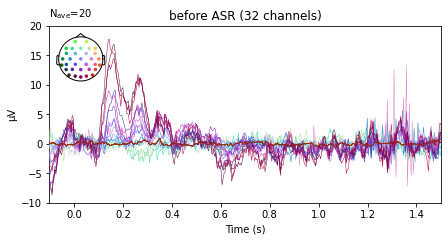

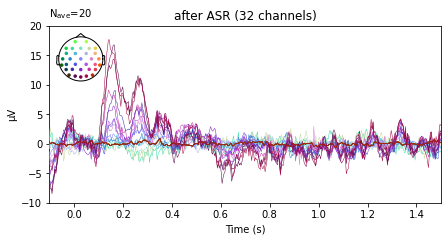

In [5]:
# set y axis limits
ylim = dict(eeg=[-10, 20])

# Plot image epoch before xdawn
noisy_avg.plot(spatial_colors=True, ylim=ylim,
               titles="before ASR")

# Plot image epoch before xdawn
clean_avg.plot(spatial_colors=True, ylim=ylim,
               titles="after ASR");